# Réseau à convolution
Jusqu'à présent, nous avons utilisé des réseaus multi-couches pleinement connectées.  Dans ce notebook, nous explorerons les réseaux à convolution, une architecture beaucoup plus adaptée à l'analyse d'images. 

In [1]:
# As usual, a bit of setup

import numpy as np
import matplotlib.pyplot as plt
from ift725.classifiers.cnn import *
from ift725.data_utils import get_CIFAR10_data
from ift725.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from ift725.layers import *
from ift725.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

run the following from the ift725 directory and try again:
python setup.py build_ext --inplace
You may also need to restart your iPython kernel


In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Convolution: propagation avant naïve
Au coeur d'une CNN est l'opération de convolution. Dans le fichier `ift725/layers.py`, vous devez implanter une couche de convolution dans la function `forward_convolutional_naive`. 

Pas besoin que le code soit efficace; vous pouvez l'implanter de la façon qui vous semble la plus facile à comprendre.

Les cellules que voici vous permettront de tester votre code:

In [3]:
x_shape = (1, 1, 4, 4)  # (N=1 batch, C=1 channels, H=4 largeur du feature map, W=4 Hauteur du feature map)
w_shape = (1, 1, 2, 2)  # (F=1 Nb feature maps en sortie, C=1 channels, HH=2 hauteur du filtre, WW=2 largeur du filtre)
x = np.floor(10*np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape))
w = np.floor(10*np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape))
b = np.floor(10*np.linspace(-0.1, 0.2, num=w.shape[0]))

correct_out = np.array([[[[5, 6, 5],
                            [6, 7, 8],
                            [8, 8, 9]]]])

print('Input = \n', x)
print('Filter = \n', w)
print('Bias = ', b)
conv_param = {'stride': 1, 'pad': 0}
out, _ = forward_convolutional_naive(x, w, b, conv_param, True)
print(out)

# Compare your output to ours; difference should be around 1e-8
print('Testing forward_convolutional_naive')
print('difference: ', rel_error(out, correct_out))

Input = 
 [[[[-1. -1. -1.  0.]
   [ 0.  1.  1.  1.]
   [ 2.  2.  3.  3.]
   [ 3.  4.  4.  5.]]]]
Filter = 
 [[[[-2. -1.]
   [ 1.  3.]]]]
Bias =  [-1.]
[[[[5. 6. 5.]
   [6. 7. 8.]
   [8. 8. 9.]]]]
Testing forward_convolutional_naive
difference:  0.0


In [4]:
from ift725.quick_layers import conv_forward_fast, conv_backward_fast

x_shape = (1, 2, 4, 4)  # (N=1 batch, C=2 channels, H=4 largeur du feature map, W=4 Hauteur du feature map)
w_shape = (1, 2, 2, 2)  # (F=1 Nb feature maps en sortie, C=2 channels, HH=2 hauteur du filtre, WW=2 largeur du filtre)
x = np.floor(10*np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape))
w = np.floor(10*np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape))
b = np.floor(10*np.linspace(-0.1, 0.2, num=w.shape[0]))

correct_out = np.array([[[[19, 21, 20],
                            [21, 22, 22],
                            [21, 22, 23]]]])

print('Input = \n', x)
print('Filter = \n', w)
print('Bias = ', b)
conv_param = {'stride': 1, 'pad': 0}
out, _ = forward_convolutional_naive(x, w, b, conv_param, True)
print(out)
print(correct_out)

# Compare your output to ours; difference should be around 1e-8
print('Testing forward_convolutional_naive')
print('difference: ', rel_error(out, correct_out))

Input = 
 [[[[-1. -1. -1. -1.]
   [-1. -1.  0.  0.]
   [ 0.  0.  0.  1.]
   [ 1.  1.  1.  1.]]

  [[ 2.  2.  2.  2.]
   [ 2.  3.  3.  3.]
   [ 3.  3.  4.  4.]
   [ 4.  4.  4.  5.]]]]
Filter = 
 [[[[-2. -2.]
   [-1.  0.]]

  [[ 0.  1.]
   [ 2.  3.]]]]
Bias =  [-1.]
[[[[19. 21. 20.]
   [21. 22. 22.]
   [21. 22. 23.]]]]
[[[[19 21 20]
   [21 22 22]
   [21 22 23]]]]
Testing forward_convolutional_naive
difference:  0.0


In [5]:
from ift725.quick_layers import conv_forward_fast, conv_backward_fast

x_shape = (1, 2, 4, 4)  # (N=1 batch, C=2 channels, H=4 largeur du feature map, W=4 Hauteur du feature map)
w_shape = (1, 2, 4, 4)  # (F=1 Nb feature maps en sortie, C=2 channels, HH=4 hauteur du filtre, WW=4 largeur du filtre)
x = np.floor(10*np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape))
w = np.floor(10*np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape))
b = np.floor(10*np.linspace(-0.1, 0.2, num=w.shape[0]))

correct_out = np.array([[[[52, 49],
                            [37, 29]]]])

print('Input = \n', x)
print('Filter = \n', w)
print('Bias = ', b)
conv_param = {'stride': 2, 'pad': 1}
out, _ = forward_convolutional_naive(x, w, b, conv_param, True)
print(out)

# Compare your output to ours; difference should be around 1e-8
print('Testing forward_convolutional_naive')
print('difference: ', rel_error(out, correct_out))

Input = 
 [[[[-1. -1. -1. -1.]
   [-1. -1.  0.  0.]
   [ 0.  0.  0.  1.]
   [ 1.  1.  1.  1.]]

  [[ 2.  2.  2.  2.]
   [ 2.  3.  3.  3.]
   [ 3.  3.  4.  4.]
   [ 4.  4.  4.  5.]]]]
Filter = 
 [[[[-2. -2. -2. -2.]
   [-2. -2. -2. -1.]
   [-1. -1. -1. -1.]
   [-1.  0.  0.  0.]]

  [[ 0.  0.  0.  1.]
   [ 1.  1.  1.  1.]
   [ 1.  2.  2.  2.]
   [ 2.  2.  2.  3.]]]]
Bias =  [-1.]
[[[[52. 49.]
   [37. 29.]]]]
Testing forward_convolutional_naive
difference:  0.0


In [6]:
x_shape = (2, 3, 4, 4)  # (N=2 batch, C=3 channels, H=4 largeur du feature map, W=4 Hauteur du feature map)
w_shape = (3, 3, 4, 4)  # (F=3 nb feature maps en sortie, C=3 channels, HH=4 hauteur du filtre, WW=4 largeur du filtre)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = forward_convolutional_naive(x, w, b, conv_param, True)
correct_out = np.array([[[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]]])

# Compare your output to ours; difference should be around 1e-8
print('Testing forward_convolutional_naive')
print('difference: ', rel_error(out, correct_out))

Testing forward_convolutional_naive
difference:  2.2121476417505994e-08


# Traiter une image pour valider une convolution

On peut également valider son code en convoluant une image couleur.  Pour ce faire, la cellule que voici charge en mémoire deux images couleurs et définit deux filtres : une filtre de détection de contours et un filtre de conversion RGB->niveaux de gris. La convolution est par la suite appliquée à chaque image. 

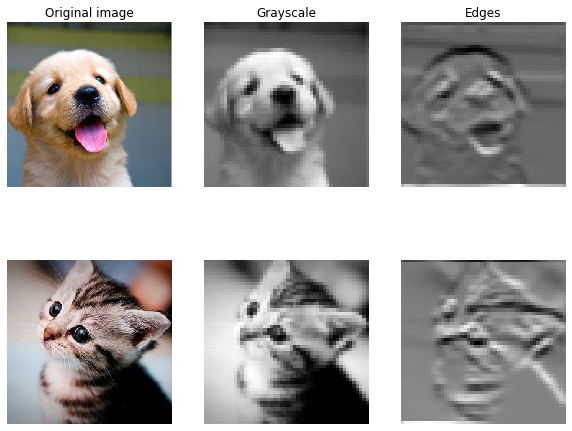

In [9]:
from matplotlib.pyplot import imread
from skimage.transform import resize

kitten, puppy = imread('kitten.jpg'), imread('puppy.jpg')
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, int(d/2):int(-d/2), :]

img_size = 50   # Make this smaller if it runs too slow
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = resize(puppy, (img_size, img_size)).transpose((2, 0, 1))
x[1, :, :, :] = resize(kitten_cropped, (img_size, img_size)).transpose((2, 0, 1))

# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 0.333, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.334, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.333, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = forward_convolutional_naive(x, w, b, {'stride': 1, 'pad': 1})

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_noax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_noax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_noax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_noax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_noax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_noax(out[1, 1])
plt.show()

# Convolution: rétropropagation naïve
Implémentez une rétropropagation convolutive naïve dans la fonction `backward_convolutional_naive` du fichier `ift725/layers.py`. Ici aussi, vous pouvez implémentez une solution simple non vectorisée.

# Question :

Avant de commencer à coder, expliquez mathématiquement en quoi consiste le gradient d'une convolution par rapport aux variables x, w et b, à savoir les variables dx, dw et db dans le code.  Pour vous aider, vous pouvez vous référez au document que voici:

https://becominghuman.ai/back-propagation-in-convolutional-neural-networks-intuition-and-code-714ef1c38199

## Votre réponse : ...


In [10]:
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: forward_convolutional_naive(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: forward_convolutional_naive(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: forward_convolutional_naive(x, w, b, conv_param)[0], b, dout)

out, cache = forward_convolutional_naive(x, w, b, conv_param)
dx, dw, db = backward_convolutional_naive(dout, cache)

# Your errors should be around 1e-9'
print('Testing backward_convolutional_naive function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))


Testing backward_convolutional_naive function
dx error:  9.616970420897713e-10
dw error:  1.715286376154763e-10
db error:  9.96075720117413e-12


# Max pooling: propagation avant naïve.
Codez une propagation avant naïve pour l'opération de max-pooling avec la fonction `forward_max_pooling_naive` dans le fichier `ift725/layers.py`.  

In [ ]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = forward_max_pooling_naive(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Compare your output with ours. Difference should be around 1e-8.
print('Testing forward_max_pooling_naive function:')
print('difference: ', rel_error(out, correct_out))

# Max pooling: rétropropagation naïve
Codez la rétro-propagation de l'opération de max-pooling via la fonction `backward_max_pooling_naive` dans le fichier `ift725/layers.py`.

Vous pouvez tester votre code avec la cellule que voici:

In [ ]:
x = np.random.randn(1, 1, 4, 4)  # (N=1 batch, C=1 channels, H=4 largeur du feature map, W=4 Hauteur du feature map)
dout = np.random.randn(1, 1, 2, 2)  # (N=1 batch, C=1 channels, H=2 largeur du feature map, W=2 Hauteur du feature map)

pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: forward_max_pooling_naive(x, pool_param)[0], x, dout)

out, cache = forward_max_pooling_naive(x, pool_param)
dx = backward_max_pooling_naive(dout, cache)

print('intput x = \n', x)
print('max_pool(x) = \n', out)
print('upcoming gradient = \n', dout)
print('gradient num = \n', dx_num)
print('gradient naive = \n', dx)

# Your error should be around 1e-12
print('Testing backward_max_pooling_naive function:')
print('dx error: ', rel_error(dx, dx_num))

In [ ]:
x = np.random.randn(3, 2, 8, 8) # (N=3 batch, C=2 channels, H=8 largeur du feature map, W=8 Hauteur du feature map)
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: forward_max_pooling_naive(x, pool_param)[0], x, dout)

out, cache = forward_max_pooling_naive(x, pool_param)
dx = backward_max_pooling_naive(dout, cache)

# Your error should be around 1e-12
print('Testing backward_max_pooling_naive function:')
print('dx error: ', rel_error(dx, dx_num))

# Convolution : version rapide
Afin de vous simplifier la vie (car nous sommes gentils après tout!) nous vous fournissons le code pour effectuer une convolution et des opération de pooling rapidement via le fichier `ift725/quick_layers.py`.

Cette version de la convolution provient d'un code Cython que vous pouvez compiler comme suit:

```bash
python setup.py build_ext --inplace
```

L'API des fonctions rapide est la même que celle des fonctions que vous avez implémenté au paravant: la propagation avant reçoit en entrée une mini-batch de données `x`, des poids `w`, `b`  et des paramètres et produit une sortie `out` ainsi qu'une `cache` pour la rétropropagation.  La rétropropagation quant à elle reçoit en entrée un gradient provenant de la fin de réseau `dout` ainsi que l'objet `cache` et retourne les gradients par rapport aux données (`dx`), aux poids (`dw`) et au biais (`bd`).

Vous pouvez comparer la différence en temps de calcul entre la version naïve et optimisée de ces fonction avec la cellule que voici:

In [18]:
from ift725.quick_layers import conv_forward_fast, conv_backward_fast
from time import time

x = np.random.randn(100, 3, 31, 31)
w = np.random.randn(25, 3, 3, 3)
b = np.random.randn(25,)
dout = np.random.randn(100, 25, 16, 16)
conv_param = {'stride': 2, 'pad': 1}

t0 = time()
out_naive, cache_naive = forward_convolutional_naive(x, w, b, conv_param)
t1 = time()
out_fast, cache_fast = conv_forward_fast(x, w, b, conv_param)
t2 = time()

print('Testing conv_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive, dw_naive, db_naive = backward_convolutional_naive(dout, cache_naive)
t1 = time()
dx_fast, dw_fast, db_fast = conv_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting conv_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))
print('dw difference: ', rel_error(dw_naive, dw_fast))
print('db difference: ', rel_error(db_naive, db_fast))

Testing conv_forward_fast:
Naive: 252.336399s
Fast: 0.040977s
Speedup: 6158.036446x
Difference:  2.8253765696723656e-11

Testing conv_backward_fast:
Naive: 106.247063s
Fast: 0.024984s
Speedup: 4252.664707x
dx difference:  9.30371165377988e-12
dw difference:  1.0
db difference:  0.0


In [19]:
from ift725.quick_layers import max_pool_forward_fast, max_pool_backward_fast

x = np.random.randn(100, 3, 32, 32)
dout = np.random.randn(100, 3, 16, 16)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

t0 = time()
out_naive, cache_naive = forward_max_pooling_naive(x, pool_param)
t1 = time()
out_fast, cache_fast = max_pool_forward_fast(x, pool_param)
t2 = time()

print('Testing pool_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('fast: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('difference: ', rel_error(out_naive, out_fast))
naive = t1 - t0
fast = t2 - t1
t0 = time()
dx_naive = backward_max_pooling_naive(dout, cache_naive)
t1 = time()
dx_fast = max_pool_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting pool_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('fast: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))
naive += t1 - t0
fast += t2 - t1

print('\nnaive', naive)
print('fast', fast)
print('naive/fast', naive/fast)

Testing pool_forward_fast:
Naive: 4.448240s
fast: 0.009994s
speedup: 445.110936x
difference:  0.0

Testing pool_backward_fast:
Naive: 5.199774s
fast: 0.046970s
speedup: 110.703838x
dx difference:  0.0

naive 9.648013353347778
fast 0.05696368217468262
naive/fast 169.3713079109169


# Couches convolutives "combo"
Nous avons utilisé des couches "combo" en combinant plusieurs opérations en une. Dans le fichier `ift725/layer_combo.py` le code de quelques opérations "combo" vous est fourni alors que d'autres ne l'est pas; à vous de le rédiger.  Vous pouvez tester votre code à l'aide des cellules que voici:

In [28]:
from ift725.layer_combo import forward_convolutional_relu, backward_convolutional_relu

x = np.random.randn(2, 3, 8, 8)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
    
out, cache = forward_convolutional_relu(x, w, b, conv_param)
dx, dw, db = backward_convolutional_relu(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: forward_convolutional_relu(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: forward_convolutional_relu(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: forward_convolutional_relu(x, w, b, conv_param)[0], b, dout)

print('Testing convolutional_relu:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing convolutional_relu:
dx error:  6.3647333510644256e-09
dw error:  1.1716536342834574e-09
db error:  8.235698378200026e-11


In [31]:
from ift725.layer_combo import forward_convolutional_relu_pool, backward_convolutional_relu_pool

x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = forward_convolutional_relu_pool(x, w, b, conv_param, pool_param)
dx, dw, db = backward_convolutional_relu_pool(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: forward_convolutional_relu_pool(x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: forward_convolutional_relu_pool(x, w, b, conv_param, pool_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: forward_convolutional_relu_pool(x, w, b, conv_param, pool_param)[0], b, dout)

print('Testing convolutional_relu_pool')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing convolutional_relu_pool
dx error:  5.871785311336438e-09
dw error:  1.0720419177361244e-09
db error:  1.856200318904271e-11


# ConvNet à trois couches
Maintenant que toutes les couches ont été codées, vous pouvez les combiner et créer un réseau à convolution à trois couches.

Dans le fichier `ift725/classifiers/cnn.py`, complétez le code de la classe `ThreeLayerConvolutionalNet`. Utilisez les cellules que voici pour débugger votre code:

## Vérification dilligente de la fonction de perte
Après avoir compléter le code de votre réseau, une des premières chose à faire est de valider la fonction de perte. Comme d'habitude, lorsqu'on initialise un réseau avec des poids aléatoire, on s'attends à ce que la perte d'une entropie croisée (sans régularisation) soit d'environ `-log(1/nb_classes)`. Avec la régularisation, la perte devrait être un peu plus élevée.

In [36]:
model = ThreeLayerConvolutionalNet()

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.3023456084550946
Initial loss (with regularization):  22.933855389338884


## Vérification du gradient
Une fois que la perte fonctionne, comme d'habitude on vérifier les fonctions de rétro-propagation à l'aide d'un gradient numérique.

In [37]:
num_inputs = 2
input_dim = (3, 16, 16)  # this is like a batch of 2 RGB images of size 16x16 
reg = 0.0
num_classes = 10
X = np.random.randn(num_inputs, *input_dim)*10
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvolutionalNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7, reg=reg,
                          dtype=np.float64)
loss, grads = model.loss(X, y)

#Should be lower than 1e-03
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-7)    
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 7.319195e-07
W2 max relative error: 1.248465e-04
W3 max relative error: 1.518387e-06
b1 max relative error: 8.513640e-06
b2 max relative error: 2.897860e-07
b3 max relative error: 1.326549e-08


## Sur-apprendre un petit ensemble de données
Une façon simple que votre réseau fonctionne bien, il est d'usage de s'assurer que le réseau est capable de sur-apprendre un petit ensemble de donnnées.  Après 10 epochs, votre réseau devrait avoir une justesse d'entraînement de plus de 85% mais une justesse de validation de moins de 25%. 

In [38]:
num_train = 40
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvolutionalNet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=10, batch_size=10,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
solver.train()

(Iteration 1 / 40) loss: 2.315277
(Epoch 0 / 10) train acc: 0.150000; val_acc: 0.073000
(Iteration 2 / 40) loss: 2.609794
(Iteration 3 / 40) loss: 7.478126
(Iteration 4 / 40) loss: 1.379068
(Epoch 1 / 10) train acc: 0.350000; val_acc: 0.089000
(Iteration 5 / 40) loss: 2.745158
(Iteration 6 / 40) loss: 1.961693
(Iteration 7 / 40) loss: 2.087230
(Iteration 8 / 40) loss: 2.232333
(Epoch 2 / 10) train acc: 0.400000; val_acc: 0.112000
(Iteration 9 / 40) loss: 1.723171
(Iteration 10 / 40) loss: 1.599148
(Iteration 11 / 40) loss: 1.234817
(Iteration 12 / 40) loss: 1.072456
(Epoch 3 / 10) train acc: 0.650000; val_acc: 0.157000
(Iteration 13 / 40) loss: 1.313860
(Iteration 14 / 40) loss: 1.043573
(Iteration 15 / 40) loss: 0.965895
(Iteration 16 / 40) loss: 0.501370
(Epoch 4 / 10) train acc: 0.575000; val_acc: 0.177000
(Iteration 17 / 40) loss: 0.616108
(Iteration 18 / 40) loss: 1.234268
(Iteration 19 / 40) loss: 0.973620
(Iteration 20 / 40) loss: 0.773186
(Epoch 5 / 10) train acc: 0.775000; val

Affichage des courbes

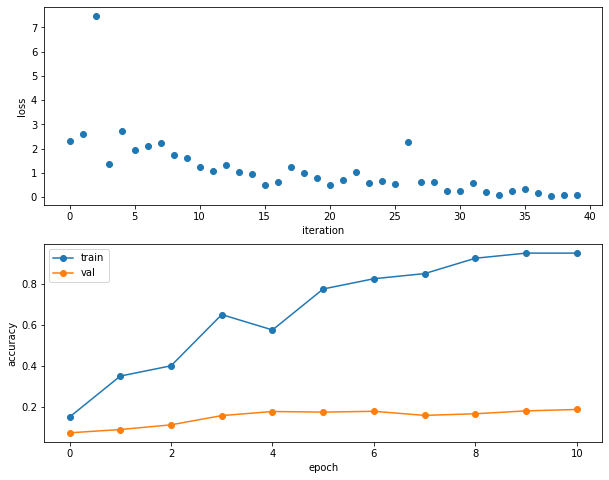

In [39]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Entraîner un réseau à convolution
Entraîner un CNN à trois couches. Après 1 epoch, vous devriez atteindre une justesse d'au moins 40% en validation.  La justesse devrait atteindre 60% après 10 epochs.  Mais attention, l'entraînement peut prendre plusieurs minutes.

In [ ]:
model = ThreeLayerConvolutionalNet(weight_scale=0.001, hidden_dim=500, reg=0.001)

solver = Solver(model, data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
solver.train()

## Visualisation des filtres
Vous pouvez visualiser les filtres de la première couche du réseau entraîné :

In [ ]:
from ift725.vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

# Spatial Batch Normalization
Nous avons vu que batch normalization est une technique fort untile pour entraîner un réseau pleinement connecté. La même technique peut être utilisée pour entrainée un CNN, mais avec quelques ajustements; c'est ce que nous appelons "spatial batch normalization."

De base, batch-norm prend en entrée un tenseur de taille `(N, D)` et produit en sortie un autre tenseur de taille `(N, D)` dont la normalisation est effectuée à travers le mini-batch de taill `N`.  Par contre, pour une couche convolutive, batch norma prend en entrée un tenseur de taille `(N, C, H, W)` et produit en sortie un autre tenseur de taille `(N, C, H, W)` où `N` est la taille du minibatch, `(H, W)` est la hauteur et la largeur du tenseur et `C` est le nombre de `feature maps`.

Le spatial batch norm calcule une moyenne et une variance pour chaque feature map `C` à travers la dimension du mini-batch `N`, et les dimensions spatiales `H` et `W`.

## Spatial batch normalization: propagation avant

Dans le fichier `ift725/layers.py`, la fonction `forward_spatial_batch_normalization` calcule la propagation avant du spatial batch norm. 

In [ ]:
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization

N, C, H, W = 2, 3, 4, 5
x = 4 * np.random.randn(N, C, H, W) + 10

print('Before spatial batch normalization:')
print('  Shape: ', x.shape)
print('  Means: ', x.mean(axis=(0, 2, 3)))
print('  Stds: ', x.std(axis=(0, 2, 3)))

# Means should be close to zero and stds close to one
gamma, beta = np.ones(C), np.zeros(C)
bn_param = {'mode': 'train'}
out, _ = forward_spatial_batch_normalization(x, gamma, beta, bn_param)
print('After spatial batch normalization:')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

# Means should be close to beta and stds close to gamma
gamma, beta = np.asarray([3, 4, 5]), np.asarray([6, 7, 8])
out, _ = forward_spatial_batch_normalization(x, gamma, beta, bn_param)
print('After spatial batch normalization (nontrivial gamma, beta):')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

In [ ]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

N, C, H, W = 10, 4, 11, 12

bn_param = {'mode': 'train'}
gamma = np.ones(C)
beta = np.zeros(C)
for t in range(50):
  x = 2.3 * np.random.randn(N, C, H, W) + 13
  forward_spatial_batch_normalization(x, gamma, beta, bn_param)
bn_param['mode'] = 'test'
x = 2.3 * np.random.randn(N, C, H, W) + 13
a_norm, _ = forward_spatial_batch_normalization(x, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After spatial batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=(0, 2, 3))) 
print('  stds: ', a_norm.std(axis=(0, 2, 3)))

## Spatial batch normalization: rétro-propagation
Dans le fichier `ift725/layers.py`, la fonction `backward_spatial_batch_normalization` implémente la rétro-propagation de cette couche.

In [ ]:
N, C, H, W = 2, 3, 4, 5
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(C)
beta = np.random.randn(C)
dout = np.random.randn(N, C, H, W)

bn_param = {'mode': 'train'}
fx = lambda x: forward_spatial_batch_normalization(x, gamma, beta, bn_param)[0]
fg = lambda a: forward_spatial_batch_normalization(x, gamma, beta, bn_param)[0]
fb = lambda b: forward_spatial_batch_normalization(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = forward_spatial_batch_normalization(x, gamma, beta, bn_param)
dx, dgamma, dbeta = backward_spatial_batch_normalization(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

# Points bonus
**10% de bonus** si vous proposez une nouvelle classe permettant d'entraîner un réseau comme celui-ci

**([conv-relu-bn]xN1-[pool])xN2 - [FC-relu]xM - [softmax]**

où *N1>=2, N2>=3* et *M>=2* et avec du *dropout*.  Le réseau doit être constitué de couches *combo*.  Votre code doit être dans les fichiers `ift725/classifiers/mycnn.py` (qu'il vous faudra créer) et `ift725/layer_combo.py`.

### Autre bonus:
**10% de bonus** si votre architecture est modulaire, c'est-à-dire que les valeurs *N1*, *N2* et *M* ne sont pas *hardcodées* mais peuvent être spécifiées dans le constructeur de la classe.

Amusez-vous bien!

In [ ]:
# Train a really good model on CIFAR-10